# NoSQL DBs - MongoDB

## 00 - Introduction

As we discussed, NoSQL DBs can fall under many sub-categories depending on the data model, e.g. key-value store, graph, wide-column, ...

All offer a inherent flexbility to representing data with respect to DBs relying on the Relational model.

Probably the most flexible approach to store and retrieve complex data is the one provided Document-oriented DBs, and among those, MongoDB is defintely the most well-known and used as of today.

https://db-engines.com/en/ranking_trend/document+store

Furthermore, MongoDB finds its place among the top 5 used DBMSs overall, topping the list of non-relational DBs.

https://www.statista.com/statistics/809750/worldwide-popularity-ranking-database-management-systems/

https://insights.stackoverflow.com/survey/2021#most-popular-technologies-database

MongoDB was originally implemented in C++, and offers a number of interfaces to work with.

We will focus on `pymongo`, the de-facto standard module to interact with MongoDB.

## 01 - Connecting to the DB and Creating collections

As for the MySQL example, a MongoDB server is already running in a docker container, mimicking an existing server to which we will connect to insert and query our databases.

The following users are created by default during the docker container spawn phase:

A `root` user is created by default with:
- user: `root`
- password: `root_pwd`

A non-`root` user is also created by default with:
- user: `my_user`
- password: `user_pwd`

#### Interactive shell

MongoDB offers a shell to allow interacting with the server directly: `mongosh`
    
We will use it very unfrequently, but it is useful to know how to access it.

We can log into the server by attaching to the running `CONTAINER ID` of the container named `mongo_db`:
    
```bash 
$ docker ps 
...
...
...
$ docker exec -it <YOUR CONTAINER ID> bash
```

And from inside the container

```bash
$ mongosh -u <EITHER ROOT OR USER> -p
``` 

Once connected to the server we can check the list of databases with:
    
```python
show databases
```

_NB_: the `mongosh` shell is quite permissive, so we don't need to end all statements with semicolons `;`

#### `pymongo`

The `pymongo` module is already installed in your docker Jupyter-notebook container.

_NB_: remember that we use the containers to replicate a server-client setup. The server is hosted in a different container from the Jupyter notebook, therefore we need to connect to the proper server IP address (in our case, simply `db`).

In [1]:
import pymongo
from pymongo import MongoClient

from pprint import pprint

import matplotlib.pyplot as plt

Create a connection to the DB.

We create a client connecting to the MongoDB server, which can be, depending on the deployment of the DB:
- the single node hosting the DB
- the primary of a replica set
- the router of the sharded cluster

On the node running MongoDB there should be an active `mongod` server to which we will connect.

This has been done automagically at the startup of the mongo docker container, but one will have to do it by hand in a different configuration (e.g. when deploying MongoDB in a non docker-based environment, or if you wanted to have a MongoDB server running on your laptop).

Luckily, MongoDB documentation is quite clear and detailed:
- [standalone](https://docs.cloudmanager.mongodb.com/tutorial/deploy-standalone/)
- [replica set](https://docs.cloudmanager.mongodb.com/tutorial/deploy-replica-set/)
- [sharded cluster](https://docs.cloudmanager.mongodb.com/tutorial/deploy-sharded-cluster/)

In [2]:
# declare a client connection to the MongoDB server 
dbc = MongoClient(username="root", 
                  password="root_pwd",
                  host="db", # in this case 'db' is the equivalent of the IP address of the server 
                             # or 'localhost' if running locally on the MongoDB server node
                 )

The client allows to inspect the content of the server, depending on the permissions associated to the authenticated user.

When connecting via as the `root` user, with administration rights over the MongoDB server(s), we can see that a number of DBs are already present by default:

These are the way MongoDB stores all information concerning users, status of the nodes, etc...
- `admin` plays a role in authentication and authorization
- `local` stores data specific to a single server, and info used in the replication process in replica sets deployment
- `config` store information about each shard, in the sharded deployment

In [3]:
print(dbc.list_database_names())

print('---')

for _ in dbc.list_databases():
    print(_)

['admin', 'config', 'local']
---
{'name': 'admin', 'sizeOnDisk': 102400, 'empty': False}
{'name': 'config', 'sizeOnDisk': 12288, 'empty': False}
{'name': 'local', 'sizeOnDisk': 40960, 'empty': False}


If connecting via a non-root user, no db should be visible by default, due to the authorization restraints following the authentication:

In [4]:
dbu = MongoClient(username="my_user", 
                  password="my_pwd",
                  host='db', 
                 )

print(dbu.list_database_names())

print('---')

for _ in dbu.list_databases():
    print(_)

[]
---


To use or to create a DB via the pymongo API, we can simply create a new "database object" by issuing the following:

```python
<DB_OBJECT> = <CLIENT>['<DB_NAME>']
```

or

```python
<DB_OBJECT> = <CLIENT>.<DB_NAME>
```

If the DB already exists, we will have pointed the newly created "database object" to it.
We can thus start inspecting its content and play with its collections.

If the DB did not exist beforehand, MongoDB will ***plan*** to create it for us.
The new DB will not be automatically created, though... 
The DB will "materialize" only once we will have inserted some content (at least 1 record) to it.


In [4]:
db = dbc['my_db']

Now we should have successfully created a `db` database object.

First, let's check once more the list of DBs hosted in mongo.

In [5]:
print(dbc.list_database_names())

print('---')

for _ in dbc.list_databases():
    print(_)

['admin', 'config', 'local']
---
{'name': 'admin', 'sizeOnDisk': 102400, 'empty': False}
{'name': 'config', 'sizeOnDisk': 12288, 'empty': False}
{'name': 'local', 'sizeOnDisk': 73728, 'empty': False}


We can now start using the db object directly.

The pymongo API will allow to inspect, create, and populate the collections easily from the `db` object.

To list the collections contained in the DB:
    
```python
db.list_collection_names()
```

or 

```python
db.list_collections()
```

In [6]:
print(db.list_collection_names())

print('---')

for _ in db.list_collections():
    pprint(_)

[]
---


Collections are created and accessed in a similar way to the creation of a db.

```python
<COLLECTION_OBJECT> = <DB_OBJECT>['<COLLECTION_NAME>']
```

or

```python
<COLLECTION_OBJECT> = <DB_OBJECT>.<COLLECTION_NAME>
```

As for the DB creation, the creation of a new collection is a ***lazy operation***, i.e. it's not done explicitely until you fill the collection with your first document.


In [7]:
col = db['my_collection']

In [8]:
print(db.list_collection_names())

print('---')

for _ in db.list_collections():
    pprint(_)

[]
---


## 02 - Inserting Documents

To verify that a DB and a collection are in fact created with the insertion of the first document we can proceed to issue a DB CRUD transaction by inserting a single document in the DB.

We can do it via either by explicitely using the `collection_object`, or by referring to the collection via `database_object.collection_name` 

```python
<DB_OBJECT>.<COLLECTION_NAME>.insert_one(<DOCUMENT>)
```

or 

```python
<COLLECTION_OBJECT>.insert_one(<DOCUMENT>)
```

In MongoDB all documents are stored as BSON, binary JSON objects.

We can insert any JSON record in MongoDB, withouth any need to pre-define the schema of the collection (~table for a RDB) or the entire DB.

Every document is identified by the document `_id`.

Please note that:
- the `_id` field can be declared explicitely
- otherwise, it is defined automatically by MongoDB upon the insertion of the record

Using the `pymongo` API, we can use a `python` dictionaries as documents.

Create 1 document entry and insert it to the newly crated collection.
- let `pymongo` assign the `_id` field automatically
- perform the insertion using the `collection_object` previously created

In [9]:
dict_ = {"field_1": "A string", 
         "field_2": 12.5,
         "field_3": [2,'1','asd'],
         "field_4": {
             "field_4-1": "foo",
             "field_4-2": "bar"
         },
        }

col.insert_one(dict_)

Create a second document.
- assign the `_id` field explicitely with an arbitrary string value
- perform the insertion calling the collection by name from the `db_object`

The value of the `_id` field can be anything you like, e.g. a string.

In [10]:
dict_ = {"_id": 'abc',
         "field_1": "B string", 
         "field_2": 2.15,
        }

# you can also store the result of the insertion in a variable
_ = db.my_collection.insert_one(dict_)

At this point both the DB and the collection previosly instantiated are actually created, and are visible when listing the server content

In [11]:
print(dbc.list_database_names())
print(db.list_collection_names())

['admin', 'config', 'local', 'my_db']
['my_collection']


We can verify that the collection is now hosting the documents we have created by issuing a `find()` on the collection.

The `find()` will produce the results of retrieving all content from the collection.

The output will be a `cursor` object, that we can use to iterate on the results.

In [12]:
for _ in db.my_collection.find():
    pprint(_)

{'_id': ObjectId('624d7cc931ff4592d5189fca'),
 'field_1': 'A string',
 'field_2': 12.5,
 'field_3': [2, '1', 'asd'],
 'field_4': {'field_4-1': 'foo', 'field_4-2': 'bar'}}
{'_id': 'abc', 'field_1': 'B string', 'field_2': 2.15}


The default `_id` is a `ObjectId`, a unique identifier of BSON format with a fixed-size of 12-bytes.

The `_id` field is a complex object created automatically by combining a number of information, including:
- the timestamp of the insertion
- the MongoDB node identifier
- an identifier of the current process 
- a counter

```bash
621774855e223c0dc836f720
TS------ID----PID-Cnt---
```

We can however redefine the `_id` depending on our application to represent any kind of data format:
- binary data
- integer
- string
- timestamp
- ...

The document `_id` can be used to retrieve documents directly, similarly to what could be done in a key-value store, or can be simply used as an internal bookkeeping info for MongoDB.

Let's stress this once more:
- MongoDB allows 2 identical documents, with different `_id` fields
- but do not allow 2 different documents, with identical `_id` fields

Try to insert 2 new documents:
1. with a different `_id` field from the previous ones
2. with the same `_id` field from a previous document

Finally, print the content of the collection

In [13]:
dict_1 = {"_id": 'def',
         "field_1": "B string", 
         "field_2": 2.15,
        }

try:
    db.my_collection.insert_one(dict_1)
    print("Successful document insertion")
except:
    print("An exception occurred")


Successful document insertion


In [14]:
dict_2 = {"_id": 'abc',
         "new_field": 123, 
         "another_field": 456,
        }

try:
    db.my_collection.insert_one(dict_2)
    print("Successful document insertion")
except:
    print("An exception occurred")

An exception occurred


List all documents inserted to check the content of the DB at this stage

In [15]:
for _ in db.my_collection.find():
    pprint(_) 

{'_id': ObjectId('624d7cc931ff4592d5189fca'),
 'field_1': 'A string',
 'field_2': 12.5,
 'field_3': [2, '1', 'asd'],
 'field_4': {'field_4-1': 'foo', 'field_4-2': 'bar'}}
{'_id': 'abc', 'field_1': 'B string', 'field_2': 2.15}
{'_id': 'def', 'field_1': 'B string', 'field_2': 2.15}


We can insert multiple documents at once via the `insert_many` method of the `pymongo` API.

The documents have to be passed as a `python` list:
    
```python
<DB_OBJECT>.<COLLECTION_NAME>.insert_many([<DOCUMENT1>,
                                           <DOCUMENT2>,
                                           <DOCUMENT3>])
```

or 

```python
<COLLECTION_OBJECT>.insert_many([<DOCUMENT1>,
                                 <DOCUMENT2>,
                                 <DOCUMENT3>])
```

Create a small set of documents and insert them in a single batch.

Store the result of the transaction in a new python variable.

In [16]:
from random import random

docs = []
for _ in range(3):
    docs.append({'_id': _,
                 'x': random(),
                 'y': random()
                })

# store the result of the transaction as a new object
res_ = db.my_collection.insert_many(docs)

pprint(res_)

The result variable contains information:
1. the newly inserted `_id`s
2. the aknowledgement response of the MongoDB server to the insertion

In [17]:
print('inserted ids:', res_.inserted_ids)
print('transfer ack:', res_.acknowledged)

inserted ids: [0, 1, 2]
transfer ack: True


## 03 - Basics on finding objects 

To query the DB and check the content of the inserted documents, the `find` method acts as the `SELECT` instruction in SQL.

```python
<DB_OBJECT>.<COLLECTION_NAME>.find()
```

or 

```python
<COLLECTION_OBJECT>.find()
```

A quite useful alternative method is `find_one`, which acts in the very same way as `find` but selects and shows only *one* document of the collection 

- retrieve all documents previously inserted in the collection with `find`
- use `find_one` to inspect one of the documents

In [18]:
for _ in db.my_collection.find():
    pprint(_)

{'_id': ObjectId('624d7cc931ff4592d5189fca'),
 'field_1': 'A string',
 'field_2': 12.5,
 'field_3': [2, '1', 'asd'],
 'field_4': {'field_4-1': 'foo', 'field_4-2': 'bar'}}
{'_id': 'abc', 'field_1': 'B string', 'field_2': 2.15}
{'_id': 'def', 'field_1': 'B string', 'field_2': 2.15}
{'_id': 0, 'x': 0.9346388933855552, 'y': 0.39036913998959355}
{'_id': 1, 'x': 0.7273522609134078, 'y': 0.013513921034636}
{'_id': 2, 'x': 0.04842831205988096, 'y': 0.6815616066435488}


In [19]:
db.my_collection.find_one()

{'_id': ObjectId('624d7cc931ff4592d5189fca'),
 'field_1': 'A string',
 'field_2': 12.5,
 'field_3': [2, '1', 'asd'],
 'field_4': {'field_4-1': 'foo', 'field_4-2': 'bar'}}

The `find` methods can be modified to return only a subsets of fields from the documents, to perform the equivalent to the SQL statement

```mysql
SELECT Attribute1, Attribute2 FROM Table;
```

In pymongo this can be achieved by enabling (1) or disabling (0) individual fields:
    
```python
<DB_OBJECT>.<COLLECTION_NAME>.find({}, 
                                   {"FIELD1":1, "FIELD2":1})
```

This operation is referred to as document *projection* over the specific fields.

**NB 1**: a peculiar quirk of MongoDB makes only possible to specify which fields to drop or to retain with either only 0 or only 1 values, and not to mix 0s and 1s in the same `find`

**NB 2**: the latter does not apply for the `_id` field, which can however be always silenced 


In [20]:
# we can do the following
try:
    _ = db.my_collection.find({},
                              {'_id':0,
                               'x'  :1,
                               'y'  :1})
    pprint([x for x in _]) 
except:
    print("An exception occurred")    

[{},
 {},
 {},
 {'x': 0.9346388933855552, 'y': 0.39036913998959355},
 {'x': 0.7273522609134078, 'y': 0.013513921034636},
 {'x': 0.04842831205988096, 'y': 0.6815616066435488}]


In [21]:
# but we cannot do the following
try:
    _ = db.my_collection.find({},
                              {'_id':0,
                               'x'  :1,
                               'y'  :0})
    pprint([x for x in _]) 
    print("Successful query")
except:
    print("An exception occurred")    

An exception occurred


Let's import a simple DB from a JSON file to start working on queries.

DBs and collections can be imported using the `mongoimport` tool directly connecting to the mongo server.
This is the preferred way, and the best alternative for large databases dumped into files.

```bash
mongoimport --username               <USER NAME> 
            --password               <USER PASSWORD>
            --db                     <DB NAME>
            --collection             <COLLECTION NAME> 
            --authenticationDatabase admin
            --file                   <.json FILE PATH>
```

As an pythonic alternative for smaller datasets, we can proceed in pymongo by:
1. creating a new DB 
2. creating a new collection
3. creating a list of documents by reading the .json file 
4. performing the insertion of all documents in the newly created collection

**NB**: when importing a json file produced by the dump of a MongoDB database, some object fields may not be interpreted correclty by the `python` json module. This is because MongoDB renames and modifies some fields (e.g. `ObjectId` into `$oid`) during the dump to json format.

We are going to use a DB from businesses rated on YELP, stored in the file: `/opt/workspace/dbs/yelp.json`

1. create a new DB named 'yelp'
2. create a new collection named 'businesses'
3. create an empty list of documents
4. loop over the .json file and append every line to the document list 
  * use the `json` module to append the `json.loads(<THE LINE>)`
5. perform an `insert_many` transaction to populate the database

In [22]:
# if necessary, drop the existing yelp database
dbc.drop_database('yelp')

In [23]:
# create a new db
db_yelp = dbc['yelp']

In [24]:
# create a new collection
db_yelp['businesses']

Collection(Database(MongoClient(host=['db:27017'], document_class=dict, tz_aware=False, connect=True), 'yelp'), 'businesses')

In [25]:
# create a list of documents 
docs_ = []

In [26]:
# read documents from the json file and fill the document list
import json
for line in open('/opt/workspace/dbs/yelp.json', 'r'):
    docs_.append(json.loads(line))
print('All done')

All done


In [27]:
# insert the documents in the db
try:
    db_yelp.businesses.insert_many(docs_)
    print("Successful insertion")
except Exception as e:
    print("An exception occurred:",e)

Successful insertion


In [28]:
# inspect the inserted data (one document)
pprint(db_yelp.businesses.find_one())

{'_id': ObjectId('624d7db331ff4592d5189fcb'),
 'address': '1616 Chapala St, Ste 2',
 'attributes': {'ByAppointmentOnly': 'True'},
 'business_id': 'Pns2l4eNsfO8kk83dixA6A',
 'categories': ['Doctors',
                'Traditional Chinese Medicine',
                'Naturopathic/Holistic',
                'Acupuncture',
                'Health & Medical',
                'Nutritionists'],
 'city': 'Santa Barbara',
 'hours': None,
 'is_open': 0,
 'latitude': 34.4266787,
 'longitude': -119.7111968,
 'name': 'Abby Rappoport, LAC, CMQ',
 'postal_code': '93101',
 'review_count': 7,
 'stars': 5.0,
 'state': 'CA'}


## 03 - Basic queries with filters

As we anticipated earlier, the `find` statement API is composed of 2 parts:
1. the query operator(s)
2. the projection

```python
<DB_OBJECT>.<COLLECTION_NAME>.find(
                                   {<QUERY OPERATORS>}, 
                                   {<DATA PROJECTION>}
                                  )
```

All query operators are passed to pymongo as a dictionaries (jsons), or a list of dictionaries.

To retrieve all documents with a specific value at a given field the json query operator is simply formatted as:

```python
{'<THE FIELD>' : 'THE VALUE'}
```

* Locate all businesses in the `state` of Florida (FL)
    * Only show the first 2 retrieved documents (by limiting the loop over the cursor)

In [29]:
# query 
q_ = {'state' : 'FL'}

# projection
p_ = {}

try:
    _ = db_yelp.businesses.find(q_, p_)
    for i in range(2):
        pprint(_[i])
except:
    print('Failed query')

{'_id': ObjectId('624d7db331ff4592d5189fd2'),
 'address': '400 Pasadena Ave S',
 'attributes': None,
 'business_id': 'qkRM_2X51Yqxk3btlwAQIg',
 'categories': ['Synagogues', 'Religious Organizations'],
 'city': 'St. Petersburg',
 'hours': {'Friday': '9:0-17:0',
           'Monday': '9:0-17:0',
           'Thursday': '9:0-17:0',
           'Tuesday': '9:0-17:0',
           'Wednesday': '9:0-17:0'},
 'is_open': 1,
 'latitude': 27.76659,
 'longitude': -82.732983,
 'name': 'Temple Beth-El',
 'postal_code': '33707',
 'review_count': 5,
 'stars': 3.5,
 'state': 'FL'}
{'_id': ObjectId('624d7db331ff4592d5189fd5'),
 'address': '21705 Village Lakes Sc Dr',
 'attributes': {'BikeParking': 'True',
                'BusinessAcceptsCreditCards': 'True',
                'BusinessParking': {'garage': 'False',
                                    'lot': 'False',
                                    'street': 'False',
                                    'valet': 'False',
                                    '

MongoDB provides a set of operators to perform more extensive queries (https://docs.mongodb.com/manual/reference/operator/query/) such as:

```python
$eq    # equal to
$ne    # not equal to
$gt    # greater than
$gte   # greater than or equal to
$lt    # less than
$lte   # less than or equal to
$in    # in the list
$nin   # not in the list
...
```

The syntax of the query is still a json-like format, with nested conditions:

```python
{'<THE FIELD>' : { 'THE CONDITION' : 'THE VALUE'} }
```

* Retrieve the `name`, `city` and `review_count` of all businesses with more than 100 `review_count`

In [30]:
# query 
q_ = {'review_count' : {'$gt' : 100} 
     }

# projection
p_ = {'_id':0, 
      'name':1,
      'city':1,
      'review_count':1
     }

try:
    _ = db_yelp.businesses.find(q_, p_)
    for i in range(10):
        pprint(_[i])
except:
    print('Failed query')

{'city': 'Philadelphia', 'name': 'Tuna Bar', 'review_count': 245}
{'city': 'Philadelphia', 'name': 'BAP', 'review_count': 205}
{'city': 'Reno', 'name': "Romano's Macaroni Grill", 'review_count': 339}
{'city': 'Nashville', 'name': 'The Green Pheasant', 'review_count': 161}
{'city': 'Ardmore', 'name': 'Ardmore Pizza', 'review_count': 109}
{'city': 'Nashville', 'name': 'Caviar & Bananas', 'review_count': 159}
{'city': 'Indianapolis', 'name': 'Twin Peaks', 'review_count': 257}
{'city': 'West Chester',
 'name': "Doc Magrogan's Oyster House - West Chester",
 'review_count': 114}
{'city': 'Wilmington',
 'name': 'Chase JP Morgan Bank Credit Card Services',
 'review_count': 111}
{'city': 'Indianapolis',
 'name': 'Bier Brewery and Tap Room',
 'review_count': 139}


More articulated queries can be performed by combining multiple conditions in a single query statement (i.e. one single json-like query).
By default, this will result in the boolean `and` of all query statements.
    
```python
{'<THE FIELD 1>' : { 'THE CONDITION 1' : 'THE VALUE 1'},
 '<THE FIELD 2>' : { 'THE CONDITION 2' : 'THE VALUE 2'} }
```    

* Retrieve the `name`, `city`, `review_count` and `stars` of all businesses with more than 100 `review_count` and with 4 or more `stars`

In [31]:
# query 
q_ = {'review_count' : {'$gt' : 100},
      'stars'        : {'$gte': 4}
     }

# projection
p_ = {'_id':0, 
      'name':1,
      'city':1,
      'review_count':1,
      'stars':1
     }

try:
    _ = db_yelp.businesses.find(q_, p_)
    for i in range(10):
        pprint(_[i])
except:
    print('Failed query')

{'city': 'Philadelphia', 'name': 'Tuna Bar', 'review_count': 245, 'stars': 4.0}
{'city': 'Philadelphia', 'name': 'BAP', 'review_count': 205, 'stars': 4.5}
{'city': 'Nashville',
 'name': 'The Green Pheasant',
 'review_count': 161,
 'stars': 4.0}
{'city': 'Indianapolis',
 'name': 'Bier Brewery and Tap Room',
 'review_count': 139,
 'stars': 4.5}
{'city': 'Santa Barbara',
 'name': 'Helena Avenue Bakery',
 'review_count': 389,
 'stars': 4.0}
{'city': 'New Orleans',
 'name': 'Copper Vine',
 'review_count': 350,
 'stars': 4.5}
{'city': 'Nashville',
 'name': "Mike's Ice Cream",
 'review_count': 593,
 'stars': 4.5}
{'city': 'New Orleans',
 'name': "Mahony's Po-Boys & Seafood",
 'review_count': 382,
 'stars': 4.0}
{'city': 'Treasure Island',
 'name': 'The Pearl',
 'review_count': 129,
 'stars': 4.0}
{'city': 'Saint Louis',
 'name': 'Budweiser Brewery Experience',
 'review_count': 605,
 'stars': 4.5}


To chain further query operators in a single statement we can use boolean operators.

```python
$and
$or
$not
$nor
```

The syntax of the query highlights the boolean operator, and applies to a list of sub-conditions, in the order:
1. the boolean operator (e.g. `$nor :`)
2. the list of all conditions affected `[ {<CONDITION 1>}, {<CONDITION 2>} ]`


```python
{'<BOOLEAN OPERATOR>' : [ { 'THE CONDITION 1' : 'THE VALUE 1'},
                          { 'THE CONDITION 2' : 'THE VALUE 2'} ] }
```    

* Perform a similar query as before by selecting the `name`, `city`, `review_count` and `stars` of all businesses with more than 100 `review_count` ***or*** with 4 or more `stars`


In [32]:
# query 
q_ = {'$or' : [
        {'review_count' : {'$gt' : 100} },
        {'stars'        : {'$gte': 4  } } 
      ] }

# projection
p_ = {'_id':0, 
      'name':1,
      'city':1,
      'review_count':1,
      'stars':1
     }

try:
    _ = db_yelp.businesses.find(q_, p_)
    for i in range(10):
        pprint(_[i])
except:
    print('Failed query')

{'city': 'Santa Barbara',
 'name': 'Abby Rappoport, LAC, CMQ',
 'review_count': 7,
 'stars': 5.0}
{'city': 'Philadelphia',
 'name': 'St Honore Pastries',
 'review_count': 80,
 'stars': 4.0}
{'city': 'Green Lane',
 'name': 'Perkiomen Valley Brewery',
 'review_count': 13,
 'stars': 4.5}
{'city': 'Tampa Bay',
 'name': 'Vietnamese Food Truck',
 'review_count': 10,
 'stars': 4.0}
{'city': 'Clearwater', 'name': 'Adams Dental', 'review_count': 10, 'stars': 5.0}
{'city': 'Largo',
 'name': "Zio's Italian Market",
 'review_count': 100,
 'stars': 4.5}
{'city': 'Philadelphia', 'name': 'Tuna Bar', 'review_count': 245, 'stars': 4.0}
{'city': 'Tucson',
 'name': 'Arizona Truck Outfitters',
 'review_count': 10,
 'stars': 4.5}
{'city': 'New Orleans',
 'name': 'Herb Import Co',
 'review_count': 5,
 'stars': 4.0}
{'city': 'Philadelphia', 'name': 'BAP', 'review_count': 205, 'stars': 4.5}


* Then, select `name`,`city`,`state` and `stars` of all businesses with 4 or more `stars` that can be found in the `state` of Colorado (CO) or Washington (WA)

There are 2 main alternatives in this case:
1. perform the **or** between the two `state` conditions, followed by the **and** of the `stars` condition
2. use the `$in` statement to search for elements in a list

In [33]:
# query 
q_ = {'stars' : {'$gte': 4},
      '$or' : [
        {'state' : 'CO'},
        {'state' : 'WA'} 
      ] 
     }

# alternative query
q_ = {'stars' : {'$gte': 4},
      'state' : {'$in': ['CO','WA'] } 
     }

# projection
p_ = {'_id':0, 
      'name':1,
      'city':1,
      'state':1,
      'stars':1
     }

try:
    _ = db_yelp.businesses.find(q_, p_)
    for i in range(10):
        pprint(_[i])
except:
    print('Failed query')

{'city': 'Dumont', 'name': 'Breeze Ski Rentals', 'stars': 4.0, 'state': 'CO'}
{'city': 'College Place',
 'name': 'Valvoline Instant Oil Change',
 'stars': 4.5,
 'state': 'WA'}
{'city': 'Denver',
 'name': 'Travis Darnell Photography',
 'stars': 4.5,
 'state': 'CO'}
Failed query


So far we have limited the output of the query by stopping displaying the results when iterating on the database cursor.

A better way to limit the results is to apply the `limit` operator directly in the query statement, thus returing only a limited amount of documents.

This can be further combined with the sorting (`sort` operator).
Differently from plain MongoDB, in `pymongo`:
1. the sorting conditions are reported in a list of tuples `[(...), (...)]`
2. the sorting direction can be stated explicitly via `pymongo.ASCENDING/DESCENDING` instead of using 1 and -1

```python
<DB_OBJECT>.<COLLECTION_NAME>.find( {<QUERY OPERATORS>}, {<DATA PROJECTION>} ) \
                             .sort( [(<FIELD 1>, pymongo.ASCENDING / 1),
                                     (<FIELD 2>, pymongo.DESCENDING / -1)] ) \
                             .limit(N)
```

* Select the first 5 businesses in the `state` of Pennsylvania (PA) with the highest `stars` rating
    * Further sort them by `city`
    * Show `name`,`city`,`state` and `stars` of all resulting documents

In [34]:
# query 
q_ = {'state' : 'PA'}

# projection
p_ = {'_id':0, 
      'name':1,
      'city':1,
      'state':1,
      'stars':1
     }

# sorting
s_ = [('stars', -1),
      ('city' ,  1)]

# limit
l_ = 5

try:
    _ = db_yelp.businesses.find(q_, p_).sort(s_).limit(l_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'city': 'Abington',
 'name': 'Emoji Sushi & Teriyaki',
 'stars': 5.0,
 'state': 'PA'}
{'city': 'Abington',
 'name': 'Mattress Outlet of Abington',
 'stars': 5.0,
 'state': 'PA'}
{'city': 'Abington', 'name': '2 Fat Dogs', 'stars': 5.0, 'state': 'PA'}
{'city': 'Abington',
 'name': 'Jay Freedman, DDS & Associates',
 'stars': 5.0,
 'state': 'PA'}
{'city': 'Abington',
 'name': 'Willard Pest Control',
 'stars': 5.0,
 'state': 'PA'}


## 04 - Queries on Nested Fields

MongoDB documents are easily nested, hosting a number of inner structures which allow us to store and organize the data more clearly.

For instance, most documents (but not necessarily all of them) in this collection have a `attributes` data structure, whose elements are further structured, e.g.:

```python
 'attributes': {'BikeParking': 'True',
                'BusinessAcceptsCreditCards': 'True',
                'BusinessParking': {'garage': 'False',
                                    'lot': 'False',
                                    'street': 'False',
                                    'valet': 'False',
                                    'validated': 'False'},
                'RestaurantsPriceRange2': '2'},
```

We can perform queries of the sub-fields of nested objects simply by accessing data with the "dot" notation `field.sub_field`

* Retrieve the five best rated businesses from Florida (FL) with at least 10 reiews with the `attributes` `GoodForKids` being equal to `'True'` 
    * Choose freely the limit and sorting of the data

In [35]:
# query 
q_ = {'attributes.GoodForKids' : 'True',
      'state' : 'FL',
      'review_count' : {'$gt': 10} }

# projection
p_ = {'_id':0, 
      'name':1,
      'city':1,
      'state':1,
      'stars':1
     }

# sorting
s_ = [('stars', -1)]

# limit
l_ = 5

try:
    _ = db_yelp.businesses.find(q_, p_).sort(s_).limit(l_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'city': 'Tampa', 'name': 'Green Locus', 'stars': 5.0, 'state': 'FL'}
{'city': 'Odessa',
 'name': 'Golden Spirit Alpaca Ranch',
 'stars': 5.0,
 'state': 'FL'}
{'city': 'Tampa', 'name': 'Above The Salt Cafe', 'stars': 5.0, 'state': 'FL'}
{'city': 'Saint Petersburg',
 'name': 'Boyd Hill Nature Preserve',
 'stars': 5.0,
 'state': 'FL'}
{'city': 'Treasure Island',
 'name': 'Parasailing The Pass',
 'stars': 5.0,
 'state': 'FL'}


With the query operators discussed so far, use the `businesses` collection of the YELP database to extract the following information:
    
1. Retrieve the name and state of the first 10 businesses with more than 2000 reviews
    * Sort the results by stars in descending order


2. Locate all businesses in Nevada (NV) or Luisiana (LA) with more than 2.5 and less than 5.0 stars ratings.
    * Sort by the number or ratings in descending order
    * Limit the query to the first 10 occurrencies
    

3. List the addresses of the first 5 businesses currently open (`is_open`) in Reno (NV) with BikeParking as an Attribute
    * Sort by stars
    

4. Find the top 5 best rated businesses having Friday `11:0-18:0` within their opening `hours`


5. Identify the most voted business in Santa Barbara (CA) offering the `BusinessParking.valet` service


6. Select the 5 best rated business in any of the follwing states (New Jersey, Indiana, Tennessee) with more than 50 ratings where `GoodForMeal.lunch` and `DogsAllowed` are both true, and where the `Ambience` is not `touristy`

#### 1 - Retrieve the name and state of the first 10 businesses with more than 2000 reviews, sorted by stars in descending order

In [36]:
# query 
q_ = {'review_count': {'$gt': 2000} }

# projection
p_ = {'_id':0, 
      'name':1,
      'state':1,
      'stars':1,
      'review_count':1
     }

# sorting
s_ = [
      ('stars', -1),
     ]

# limit
l_ = 10

try:
    _ = db_yelp.businesses.find(q_, p_).sort(s_).limit(l_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'name': 'Prep & Pastry', 'review_count': 2126, 'stars': 4.5, 'state': 'AZ'}
{'name': "Jacques-Imo's Cafe",
 'review_count': 2406,
 'stars': 4.5,
 'state': 'LA'}
{'name': "Commander's Palace",
 'review_count': 4876,
 'stars': 4.5,
 'state': 'LA'}
{'name': 'The Stillery', 'review_count': 2588, 'stars': 4.5, 'state': 'TN'}
{'name': "Surrey's Café & Juice Bar",
 'review_count': 2084,
 'stars': 4.5,
 'state': 'LA'}
{'name': 'Zahav', 'review_count': 3065, 'stars': 4.5, 'state': 'PA'}
{'name': 'Parkway Bakery & Tavern',
 'review_count': 2160,
 'stars': 4.5,
 'state': 'LA'}
{'name': 'Peg Leg Porker', 'review_count': 2878, 'stars': 4.5, 'state': 'TN'}
{'name': 'The Eagle', 'review_count': 2233, 'stars': 4.5, 'state': 'IN'}
{'name': 'District Donuts Sliders Brew',
 'review_count': 2062,
 'stars': 4.5,
 'state': 'LA'}


#### 2 - Locate all businesses in Nevada (NV) or Luisiana (LA) with more than 2.5 and less than 5.0 stars ratings, sorted by the number or ratings in descending order; limit the query to the first 10 occurrencies

In [37]:
# query 
q_ = {'state': {'$in': ['NV','LA'] },
      '$and' : [
          {'stars': {'$lt': 4}},
          {'stars': {'$gt': 2.5}}
      ]}

# projection
p_ = {'_id':0, 
      'name':1,
      'state':1,
      'stars':1,
      'review_count':1
     }

# sorting
s_ = [
      ('review_count', -1),
     ]

# limit
l_ = 10

try:
    _ = db_yelp.businesses.find(q_, p_).sort(s_).limit(l_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'name': "Mother's Restaurant",
 'review_count': 5185,
 'stars': 3.5,
 'state': 'LA'}
{'name': 'Grand Sierra Resort and Casino',
 'review_count': 3345,
 'stars': 3.0,
 'state': 'NV'}
{'name': "Drago's Seafood Restaurant",
 'review_count': 3160,
 'stars': 3.5,
 'state': 'LA'}
{'name': "Coop's Place", 'review_count': 3157, 'stars': 3.5, 'state': 'LA'}
{'name': "Deanie's Seafood", 'review_count': 2473, 'stars': 3.5, 'state': 'LA'}
{'name': 'Bourbon House', 'review_count': 2026, 'stars': 3.5, 'state': 'LA'}
{'name': 'The Court of Two Sisters',
 'review_count': 1827,
 'stars': 3.5,
 'state': 'LA'}
{'name': 'Louis Armstrong New Orleans International Airport  MSY',
 'review_count': 1789,
 'stars': 3.0,
 'state': 'LA'}
{'name': 'Silver Legacy Resort Casino',
 'review_count': 1534,
 'stars': 3.0,
 'state': 'NV'}
{'name': "Antoine's Restaurant",
 'review_count': 1460,
 'stars': 3.5,
 'state': 'LA'}


#### 3 - List the addresses of the first 5 businesses currently open (`is_open`) in Reno (NV) with BikeParking as an Attribute, sorted by stars

In [38]:
# query 
q_ = {'city': 'Reno',
      'state': 'NV',
      'is_open': 1,
      'attributes.BikeParking' : 'True'}

# projection
p_ = {'_id':0, 
      'name':1,
      'address':1,
      'postal_code':1,
      'review_count':1,
      'stars':1,
     }

# sorting
s_ = [
      ('stars', -1),
     ]

# limit
l_ = 5

try:
    _ = db_yelp.businesses.find(q_, p_).sort(s_).limit(l_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'address': '8056 South Virginia St, Ste 1',
 'name': 'Orangetheory Fitness Reno',
 'postal_code': '89511',
 'review_count': 69,
 'stars': 5.0}
{'address': '340 Kietzke Ln',
 'name': 'El Carrito',
 'postal_code': '89502',
 'review_count': 6,
 'stars': 5.0}
{'address': '9730 S McCarran Blvd, Ste 1',
 'name': 'Terance Cochran, OD-Cochrane Family Eyecare',
 'postal_code': '89523',
 'review_count': 29,
 'stars': 5.0}
{'address': '2187 Market St, Ste A',
 'name': 'Road Rider of Reno',
 'postal_code': '89502',
 'review_count': 8,
 'stars': 5.0}
{'address': '577 South Meadows Pkwy, Ste 6, Reno Breathe Bar',
 'name': 'Lush Ink & Skin Studio',
 'postal_code': '89521',
 'review_count': 6,
 'stars': 5.0}


#### 4 - Find the top 5 best rated businesses having Friday `11:0-18:0` within their opening `hours`

In [39]:
# query 
q_ = {'hours.Friday' : '11:0-18:0'}

# projection
p_ = {'_id':0, 
      'name':1,
      'address':1,
      'postal_code':1,
      'review_count':1,
      'stars':1,
     }

# sorting
s_ = [
      ('stars', -1),
     ]

# limit
l_ = 5

try:
    _ = db_yelp.businesses.find(q_, p_).sort(s_).limit(l_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'address': '240 S Broad St',
 'name': 'Studio 240',
 'postal_code': '08096',
 'review_count': 7,
 'stars': 5.0}
{'address': '2940 Canal St',
 'name': 'WobbeMassage',
 'postal_code': '70119',
 'review_count': 30,
 'stars': 5.0}
{'address': '8465 Keystone Crossing, Ste 220',
 'name': 'Noble Jewelry Appraisers',
 'postal_code': '46240',
 'review_count': 5,
 'stars': 5.0}
{'address': '259 Marlton Pike E',
 'name': 'Sunrise Surf And Skateboard Shop',
 'postal_code': '08034',
 'review_count': 8,
 'stars': 5.0}
{'address': '4611 Alabama Ave',
 'name': 'The Pepper Pott',
 'postal_code': '37209',
 'review_count': 18,
 'stars': 5.0}


It is possible to use Pandas to visualize the results of the queries.

From a query we return a cursor object containing a "pointer" to the list of json-like results (dictionaries).

In Pandas, we can create a DataFrame out of it by doing the following:
    
```python
import pandas as pd
df = pd.DataFrame(list(<QUERY RESULT>))
```

In [40]:
import pandas as pd

try:
    _ = db_yelp.businesses.find(q_, p_).sort(s_).limit(l_)
    df = pd.DataFrame(list(_))
except:
    print('Failed query')
    
df

,name,address,postal_code,stars,review_count
0,Studio 240,240 S Broad St,08096,5.0,7
1,WobbeMassage,2940 Canal St,70119,5.0,30
2,Noble Jewelry Appraisers,"8465 Keystone Crossing, Ste 220",46240,5.0,5
3,Sunrise Surf And Skateboard Shop,259 Marlton Pike E,08034,5.0,8
4,The Pepper Pott,4611 Alabama Ave,37209,5.0,18


#### 5 - Identify the most voted business in Santa Barbara (CA) offering the `BusinessParking.valet` service

In [41]:
# query 
q_ = {'city' : 'Santa Barbara',
      'state' : 'CA',
      'attributes.BusinessParking.valet' : 'True'}

# projection
p_ = {'_id':0, 
      'name':1,
      'address':1,
      'postal_code':1,
      'review_count':1,
      'latitude':1,
      'longitude':1,
      'stars':1,
     }

# sorting
s_ = [
      ('review_count', -1),
     ]

# limit
l_ = 5

try:
    _ = db_yelp.businesses.find(q_, p_)#.sort(s_).limit(l_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'address': '1198 Coast Village Rd',
 'latitude': 34.4213337,
 'longitude': -119.6449814,
 'name': "Oliver's",
 'postal_code': '93108',
 'review_count': 313,
 'stars': 4.5}
{'address': '15 East Cabrillo Blvd',
 'latitude': 34.412758,
 'longitude': -119.688965,
 'name': 'Bluewater Grill - Santa Barbara',
 'postal_code': '93101',
 'review_count': 768,
 'stars': 4.0}
{'address': '1 State St',
 'latitude': 34.412192,
 'longitude': -119.689592,
 'name': 'Due Lune Cucina',
 'postal_code': '93101',
 'review_count': 79,
 'stars': 4.0}
{'address': '217 G Stearns Wharf',
 'latitude': 34.4100065,
 'longitude': -119.6855487,
 'name': 'Deep Sea Tasting Room',
 'postal_code': '93101',
 'review_count': 472,
 'stars': 4.0}
{'address': '1260 Channel Dr',
 'latitude': 34.417406,
 'longitude': -119.642096,
 'name': 'Spa at Four Seasons Resort The Biltmore Santa Barbara',
 'postal_code': '93108',
 'review_count': 34,
 'stars': 4.0}
{'address': '1111 E Cabrillo Blvd',
 'latitude': 34.4176524,
 'longitude':

In [42]:
# import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline 

# try:
#     _ = db_yelp.businesses.find(q_, p_).sort(s_).limit(l_)
#     df = pd.DataFrame(list(_))
# except:
#     print('Failed query')
    
# plt.scatter('review_count', 
#             'stars', 
#             data=df)

#### 6 - Select the 5 best rated business in any of the follwing states (New Jersey, Indiana, Tennessee) with more than 50 ratings where `GoodForMeal.lunch` and `DogsAllowed` are both true, and where the `Ambience` is not `touristy`

In [43]:
# query 
q_ = {'state' : {'$in': ['NJ', 'IN', 'TN']},
      'attributes.GoodForMeal.lunch' : 'True',
      'attributes.DogsAllowed' : 'True',
      'attributes.Ambience.touristy' : 'False'}

# projection
p_ = {'_id':0, 
      'name':1,
      'address':1,
      'city':1,
      'postal_code':1,
      'review_count':1,
      'stars':1,
     }

# sorting
s_ = [
      ('review_count', -1),
     ]

# limit
l_ = 5

try:
    _ = db_yelp.businesses.find(q_, p_).sort(s_).limit(l_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'address': '903 Gleaves St',
 'city': 'Nashville',
 'name': 'Peg Leg Porker',
 'postal_code': '37203',
 'review_count': 2878,
 'stars': 4.5}
{'address': '410 Massachusetts Ave',
 'city': 'Indianapolis',
 'name': 'Bru Burger Bar - Indianapolis',
 'postal_code': '46204',
 'review_count': 1608,
 'stars': 4.0}
{'address': '225 W Washington St',
 'city': 'Indianapolis',
 'name': 'Cafe Patachou',
 'postal_code': '46204',
 'review_count': 1106,
 'stars': 4.0}
{'address': '2000 Meridian Blvd, Ste 110',
 'city': 'Franklin',
 'name': 'Tupelo Honey',
 'postal_code': '37067',
 'review_count': 999,
 'stars': 4.0}
{'address': '120 4th Ave S',
 'city': 'Franklin',
 'name': "Puckett's Grocery & Restaurant",
 'postal_code': '37064',
 'review_count': 850,
 'stars': 4.0}


## 05 - Queries on Arrays and List Elements

Queries of fields containing lists can be performed with the same syntax of any other field.

In a list, however, the order of the elements is extremely important:

```python
list_1 = ['a','b','c'] 
list_1[0] = 'a'
```

```python
list_2 = ['c','b','a'] 
list_2[0] = 'c'
```

This is reflected in the search statements, as the following two queries will return a completely different result:

```python
<DB_OBJECT>.<COLLECTION_NAME>.find( { <LIST FIELD> : [<ELEMENT A>, <ELEMENT B>] } )
```

```python
<DB_OBJECT>.<COLLECTION_NAME>.find( { <LIST FIELD> : [<ELEMENT B>, <ELEMENT A>] } )
```

When searching for all documents containing an element in any possible position within an array, the following, less stringent, notation is allowed:

```python
<DB_OBJECT>.<COLLECTION_NAME>.find( { <LIST FIELD> : <ANY ELEMENT> } )
```

If the specific ordering of the list is instead known, the query can be performed by explicitly addressing the i-th element of the list using the dot notation:

```python
<DB_OBJECT>.<COLLECTION_NAME>.find( { <LIST FIELD.i> : <i-th ELEMENT> } )
```

Test the query on lists by searching the businesses where the list `categories` have:

(For all queries, sort by stars in descending order and show only the name of the 5 best rated businesses, together with their categories)

1. The terms `Doctors` and `Health & Medical` in this specific order


2. The terms `Health & Medical` and `Doctors` in this specific order


3. The term `Doctors` anywhere in the list


4. The term `Doctors` as the 3rd element of the list




In [44]:
# query 
q_ = {'categories': ['Doctors', 'Health & Medical']}

# projection
p_ = {'_id':0,
      'name':1,
      'categories':1
     }

# sorting
s_ = [('stars', -1)]

# limit
l_ = 5

try:
    _ = db_yelp.businesses.find(q_, p_).sort(s_).limit(l_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'categories': ['Doctors', 'Health & Medical'], 'name': 'Douglas Politz, MD'}
{'categories': ['Doctors', 'Health & Medical'],
 'name': 'White Robin Southward, MD'}
{'categories': ['Doctors', 'Health & Medical'], 'name': 'Tokazewski Jeffrey MD'}
{'categories': ['Doctors', 'Health & Medical'], 'name': 'Blue Fish Pediatrics'}
{'categories': ['Doctors', 'Health & Medical'], 'name': 'Spectra Health Care'}


In [45]:
# query 
q_ = {'categories': ['Health & Medical','Doctors']}

# projection
p_ = {'_id':0,
      'name':1,
      'categories':1
     }

# sorting
s_ = [('stars', -1)]

# limit
l_ = 5

try:
    _ = db_yelp.businesses.find(q_, p_).sort(s_).limit(l_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'categories': ['Health & Medical', 'Doctors'], 'name': 'Mangel Joseph Dr'}
{'categories': ['Health & Medical', 'Doctors'],
 'name': 'Michelle Eisenhower MD'}
{'categories': ['Health & Medical', 'Doctors'], 'name': "Men's Medical"}
{'categories': ['Health & Medical', 'Doctors'], 'name': 'Kline Sarah B MD'}
{'categories': ['Health & Medical', 'Doctors'],
 'name': 'Ambulatory Surgery Center'}


In [46]:
# query 
q_ = {'categories' : 'Doctors'}

# projection
p_ = {'_id':0,
      'name':1,
      'categories':1
     }

# sorting
s_ = [('stars', -1)]

# limit
l_ = 5

try:
    _ = db_yelp.businesses.find(q_, p_).sort(s_).limit(l_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'categories': ['Rehabilitation Center',
                'Health & Medical',
                'Physical Therapy',
                'Doctors',
                'Sports Medicine'],
 'name': 'BayLife Physical Therapy and Rehabilitation- St. Petersburg'}
{'categories': ['Oncologist', 'Health & Medical', 'Surgeons', 'Doctors'],
 'name': 'Clayman Thyroid Center'}
{'categories': ['Health & Medical',
                'Medical Centers',
                'Chiropractors',
                'Nutritionists',
                'Doctors',
                'Urgent Care',
                'Naturopathic/Holistic'],
 'name': 'Thrive! Wellness Center'}
{'categories': ['Health & Medical',
                'Sports Medicine',
                'Doctors',
                'Radiologists'],
 'name': 'IU Health Physicians Artistry'}
{'categories': ['Doctors',
                'Traditional Chinese Medicine',
                'Naturopathic/Holistic',
                'Acupuncture',
                'Health & Medical',
              

In [47]:
# query 
q_ = {'categories.2' : 'Doctors'}

# projection
p_ = {'_id':0,
      'name':1,
      'categories':1
     }

# sorting
s_ = [('stars', -1)]

# limit
l_ = 5

try:
    _ = db_yelp.businesses.find(q_, p_).sort(s_).limit(l_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'categories': ['Sports Medicine',
                'Acupuncture',
                'Doctors',
                'Health & Medical',
                'Family Practice',
                'Naturopathic/Holistic'],
 'name': 'Hop MD'}
{'categories': ['Health & Medical',
                'Sports Medicine',
                'Doctors',
                'Radiologists'],
 'name': 'IU Health Physicians Artistry'}
{'categories': ['Pediatricians',
                'Podiatrists',
                'Doctors',
                'General Dentistry',
                'Dentists',
                'Health & Medical',
                'Pediatric Dentists'],
 'name': 'Homer Sedighi, DMD'}
{'categories': ['Professional Services',
                'Optometrists',
                'Doctors',
                'Health & Medical',
                'Eyewear & Opticians',
                'Shopping'],
 'name': 'Valley Forge Eye Care'}
{'categories': ['Health & Medical', 'Allergists', 'Doctors'],
 'name': 'Uptown Allergy & Asthma'}


## 06 - More on Basic Queries

Let's combine all basic filters in more articulated queries using the `mflix` database.

Preliminary operations:
* Import the `/opt/workspace/dbs/movies.json` file in the `mflix` databse and `movies` collection 
    * The file contains `$oid` structure instead of `ObjectId` as `_id` field, so the best alternative is to import it via `mongoimport` (from the `mongo` container, with the command presented here [*])
* Create the database cursor object and/or the associated collection object 
* Inspect a few documents to understand the intrinsic "schema" of the records

[*]
```bash
mongoimport --username               <USER NAME> 
            --password               <USER PASSWORD>
            --db                     <DB NAME>
            --collection             <COLLECTION NAME> 
            --authenticationDatabase admin
            --file                   <.json FILE PATH>
```

In [48]:
db_mflix = dbc['mflix']

In [49]:
col_movies = db_mflix.movies

In [52]:
# import the DB from mongosh [see instructions]

In [50]:
pprint(db_mflix.movies.find_one())

{'_id': ObjectId('573a1390f29313caabcd4135'),
 'awards': {'nominations': 0, 'text': '1 win.', 'wins': 1},
 'cast': ['Charles Kayser', 'John Ott'],
 'countries': ['USA'],
 'directors': ['William K.L. Dickson'],
 'fullplot': 'A stationary camera looks at a large anvil with a blacksmith '
             'behind it and one on either side. The smith in the middle draws '
             'a heated metal rod from the fire, places it on the anvil, and '
             'all three begin a rhythmic hammering. After several blows, the '
             'metal goes back in the fire. One smith pulls out a bottle of '
             'beer, and they each take a swig. Then, out comes the glowing '
             'metal and the hammering resumes.',
 'genres': ['Short'],
 'imdb': {'id': 5, 'rating': 6.2, 'votes': 1189},
 'lastupdated': '2015-08-26 00:03:50.133000000',
 'num_mflix_comments': 1,
 'plot': 'Three men hammer on an anvil and pass a bottle of beer around.',
 'rated': 'UNRATED',
 'released': datetime.datetime

1. Select the 5 highest imdb-rated movies produced after 1990 with at least one award nomination
    * Let's stop here and disuss all together the results...


2. Select any film with genre `Short` with a rotten tomatoes rating greater than 8.5. Sort them by descending year and Rotten Tomatoes meter
    * List the first 10


3. Identify the films with `Christopher Nolan` as the one and only director (no co-directors). Which one of them was the oldest released to win at least 2 awards?


4. Find all movies by `Peter Jackson` with genre `Fantasy` or `Adventure` with a Rotten Tomatoes meter for both Critic and Viewers greater than 80. 
    * Do you think you will find the `The Hobbit` movies in this list?

#### 1 - Select the 5 highest imdb-rated movies produced after 1990 with at least one award nomination

In [51]:
# query 
q_ = {'year' : {'$gt' : 1990},
      'awards.nominations' : {'$gte' : 1},
      'imdb.rating' : {'$ne' : ''}
     }

# projection
p_ = {'_id':0,
      'title':1,
      'year':1,
      'awards':1,
      'imdb':1,
     }

# sorting
s_ = [('imdb.rating', -1)]

# limit
l_ = 5

try:
    _ = db_mflix.movies.find(q_, p_).sort(s_).limit(l_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'awards': {'nominations': 24,
            'text': 'Won 1 Golden Globe. Another 33 wins & 24 nominations.',
            'wins': 34},
 'imdb': {'id': 185906, 'rating': 9.6, 'votes': 183802},
 'title': 'Band of Brothers',
 'year': 2001}
{'awards': {'nominations': 14,
            'text': 'Won 4 Primetime Emmys. Another 10 wins & 14 nominations.',
            'wins': 14},
 'imdb': {'id': 795176, 'rating': 9.5, 'votes': 82896},
 'title': 'Planet Earth',
 'year': 2006}
{'awards': {'nominations': 16,
            'text': 'Nominated for 7 Oscars. Another 16 wins & 16 nominations.',
            'wins': 23},
 'imdb': {'id': 111161, 'rating': 9.3, 'votes': 1521105},
 'title': 'The Shawshank Redemption',
 'year': 1994}
{'awards': {'nominations': 16,
            'text': 'Nominated for 7 Oscars. Another 16 wins & 16 nominations.',
            'wins': 23},
 'imdb': {'id': 111161, 'rating': 9.3, 'votes': 1513145},
 'title': 'The Shawshank Redemption',
 'year': 1994}
{'awards': {'nominations': 12,
     

We have a duplicate entry!
`The Shawshank Redemption` is present twice in this list. 

We might want to can get rid of duplicates with the MongoDB equivalent to the SQL `DISTINCT` statement.

In pymongo a `distinct` method can be used as an ***alternative*** to `find`
    
```python
<DB_OBJECT>.<COLLECTION_NAME>.distinct(
                                   {<FIELD TO ACT WITH DISTINCT>}, 
                                   {<FILTER OPERATION>}
                                  )
```

**However**, quite unfortunately we cannot easily combine a `distinct` statement with a `sort` or a `limit`. For that we need to use *aggregations*, which will be discussed later on...

In [52]:
# distinct field 
d_ = 'title'

try:
    _ = db_mflix.movies.distinct(d_,q_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

'!Women Art Revolution'
'#chicagoGirl: The Social Network Takes on a Dictator'
'$9.99'
'$ellebrity'
"'71"
"'R Xmas"
"'Til Madness Do Us Part"
"'Twas the Night"
'(500) Days of Summer'
'(T)ERROR'
'009 Re: Cyborg'
'06/05'
'1'
'1, 2, 3, Freeze'
'1,000 Times Good Night'
'1-900'
'1. Mai'
'10 Items or Less'
'10 Minutes'
'10 Things I Hate About You'
'10%: What Makes a Hero?'
'10,000 Black Men Named George'
'10.000 Km'
'10.5'
'10.5: Apocalypse'
'100 Bloody Acres'
'100 Girls'
'100% Love'
'1001 Grams'
'101 Dalmatians'
"101 Dalmatians II: Patch's London Adventure"
'101 Reykjavèk'
'102 Dalmatians'
'102 Minutes That Changed America'
'1066: The Battle for Middle Earth'
'11 Flowers'
'11 Minutes'
'11.6'
'11:11'
'11:14'
'12'
'12 Angry Men'
'12 Dates of Christmas'
"12 O'Clock Boys"
'12 Storeys'
'12 Years a Slave'
'12 and Holding'
'12 in a Box'
'127 Hours'
'12:01'
'12:08 East of Bucharest'
'12th & Delaware'
'13 Assassins'
'13 Going on 30'
'13 Minutes'
'13 Sins'
'13 Tzameti'
'13: Game of Death'
'14 Blades'

'First Person Plural'
'First Position'
'First Snow'
'First Squad: The Moment of Truth'
'First Winter'
'Fish & Cat'
'Fish Story'
'Fish Tank'
'Fish and Elephant'
'Fist of Jesus'
'Fist of Legend'
'Fists of Legend'
'Five'
'Five Broken Cameras'
'Five Minutes of Heaven'
'Five Star'
'Fixing Frank'
'Fiza'
'Flag Wars'
'Flags of Our Fathers'
'Flame and Citron'
'Flamenco'
'Flanders'
'Flannel Pajamas'
'Flash'
'Flash Point'
'Flashback - Mèrderische Ferien'
'Flawless'
'Flicka'
'Flicka 2'
'Flicka: Country Pride'
'Flicker'
'Flickering Lights'
'Flight'
'Flight 93'
'Flight of the Phoenix'
'Flight of the Red Balloon'
'Flightplan'
'Flipped'
'Flipper'
'Flipping Out'
'Flirting'
'Flirting with Disaster'
'Floating Skyscrapers'
'Flood'
'Floundering'
'Flow: For Love of Water'
'Flower & Garnet'
'Flower in the Pocket'
'Flowers for Algernon'
'Flowers in the Attic'
'Flowers of Shanghai'
'Flu'
'Flubber'
'Fluke'
'Flushed Away'
'Fly Away'
'Fly Away Home'
'Fly Away Solo'
'Fly Me to the Moon 3D'
'Flyboys'
'Flying Home'


'Madeinusa'
'Madeline'
'Mademoiselle'
'Mademoiselle Chambon'
"Madonna's Pig"
'Madonna: Truth or Dare'
'Madras Cafe'
'Madrid, 1987'
'Maelstrom'
'Maggie'
'Magi i luften'
'Magic & Bird: A Courtship of Rivals'
'Magic Beyond Words: The JK Rowling Story'
'Magic Hunter'
'Magic Magic'
'Magic Mike'
'Magic Mike XXL'
'Magic in the Moonlight'
'Magic in the Water'
'Magical Girl'
'Magician: The Astonishing Life and Work of Orson Welles'
'Magnificat'
'Magnolia'
'Magnus'
'Mahjong'
'Mahler on the Couch'
'Maicol Jecson'
'Maid in Manhattan'
'Maidan'
'Maidentrip'
'Maids'
'Maiko haaaan!!!'
'Main Hoon Na'
'Main Madhuri Dixit Banna Chahti Hoon!'
'Main Prem Ki Diwani Hoon'
'Main Street'
'Mais Uma Vez Amor'
'Majesty'
'Major League II'
'Majority'
'Make Yourself at Home'
'Making Plans for Lena'
'Making the Boys'
'Maktub'
'Mala Mala'
'Mala Moskwa'
'Maladies'
'Malcolm X'
"Maledetto il giorno che t'ho incontrato"
'Maleficent'
"Malibu's Most Wanted"
'Malèna'
'Mama'
'Mamay'
'Mambo Italiano'
'Mamitas'
'Mamma Mia!'
'Ma

'The Bench'
'The Benchwarmers'
'The Benefactor'
'The Berlin File'
'The Best Exotic Marigold Hotel'
'The Best Intentions'
'The Best Man'
'The Best Man Holiday'
'The Best Movie'
'The Best Offer'
'The Best Things in the World'
'The Best of Men'
'The Best of Times'
'The Best of Youth'
'The Betrayal - Nerakhoon'
'The Better Angels'
'The Bible'
'The Big Ask'
'The Big Bad Swim'
'The Big Kahuna'
'The Big Lebowski'
'The Big Picture'
'The Big Wedding'
'The Billionaire'
'The Bird People in China'
'The Birdcage'
'The Black Balloon'
'The Black Dahlia'
'The Black Panthers: Vanguard of the Revolution'
'The Black Power Mixtape 1967-1975'
'The Blade'
'The Blair Witch Project'
'The Blind Flyers'
'The Blind Side'
'The Blind Sunflowers'
'The Blind Swordsman: Zatoichi'
'The Bling Ring'
'The Blood Lands'
'The Bloody Olive'
'The Blossoming of Maximo Oliveros'
'The Blue Butterfly'
'The Blue Kite'
'The Blue Planet'
'The Blue Room'
'The Blue Umbrella'
'The Body'
'The Bodyguard'
'The Bomber'
'The Bone Collector'

#### 2 - Select any film with genre `Short` with a rotten tomatoes rating greater than 8.5. Sort them by descending year and Rotten Tomatoes meter; and list the first 10.

In [53]:
# query 
q_ = {'genres' : 'Short',
      'tomatoes.viewer.rating' : {'$gte' : 3.5}
     }

# projection
p_ = {'_id':0,
      'title':1,
      'year':1,
      'tomatoes':1,
     }

# sorting
s_ = [('year', -1),('tomatoes.viewer.meter', -1)]

# limit
l_ = 10

try:
    _ = db_mflix.movies.find(q_, p_).sort(s_).limit(l_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'title': 'Toy Story of Terror',
 'tomatoes': {'critic': {'meter': 92, 'numReviews': 13, 'rating': 8.6},
              'dvd': datetime.datetime(2014, 8, 19, 0, 0),
              'fresh': 12,
              'lastUpdated': datetime.datetime(2015, 9, 10, 19, 43, 40),
              'production': 'Disney Pixar',
              'rotten': 1,
              'viewer': {'meter': 84, 'numReviews': 2282, 'rating': 4.1}},
 'year': 2013}
{'title': 'Mr Hublot',
 'tomatoes': {'lastUpdated': datetime.datetime(2015, 9, 11, 18, 10, 25),
              'viewer': {'meter': 83, 'numReviews': 106, 'rating': 4}},
 'year': 2013}
{'title': 'The Blue Umbrella',
 'tomatoes': {'lastUpdated': datetime.datetime(2015, 9, 12, 18, 15, 28),
              'production': 'Walt Disney Pictures',
              'viewer': {'meter': 80, 'numReviews': 256, 'rating': 4}},
 'year': 2013}
{'title': 'The Education of Mohammad Hussein',
 'tomatoes': {'dvd': datetime.datetime(2013, 12, 3, 0, 0),
              'lastUpdated': datetime.datet

#### 3 - Identify the films with `Christopher Nolan` as the one and only director (no co-directors). Which one of them was the oldest released to win at least 2 awards?

In [54]:
# query 
q_ = {'directors' : ['Christopher Nolan'],
      'awards.wins' : {'$gte' : 2}
     }

# projection
p_ = {'_id':0,
      'title':1,
      'year':1,
      'directors':1,
      'awards':1,
     }

# sorting
s_ = [('year', 1)]

# limit
l_ = 1

try:
    _ = db_mflix.movies.find(q_, p_).sort(s_).limit(l_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'awards': {'nominations': 4, 'text': '5 wins & 4 nominations.', 'wins': 5},
 'directors': ['Christopher Nolan'],
 'title': 'Following',
 'year': 1998}


#### 4 - Find all movies by `Peter Jackson` with genre `Fantasy` or `Adventure` with a Rotten Tomatoes meter for both Critic and Viewers greater than 80.  

In [55]:
# query 
q_ = {'directors' : 'Peter Jackson',
      '$or' : [ {'genres' : 'Fantasy' },
                {'genres' : 'Adventure'} ],
      '$and': [ {'tomatoes.viewer.meter' : {'$gt' : 80} },
                {'tomatoes.critic.meter' : {'$gt' : 80} },]
     }

# projection
p_ = {'_id':0,
      'title':1,
      'year':1,
      'genres':1,
      'directors':1,
      'tomatoes':1,
     }

try:
    _ = db_mflix.movies.find(q_,p_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'directors': ['Peter Jackson'],
 'genres': ['Adventure', 'Fantasy'],
 'title': 'The Lord of the Rings: The Fellowship of the Ring',
 'tomatoes': {'boxOffice': '$313.8M',
              'consensus': 'Full of eye-popping special effects, and featuring '
                           'a pitch-perfect cast, The Lord of the Rings: The '
                           "Fellowship of the Ring brings J.R.R. Tolkien's "
                           'classic to vivid life.',
              'critic': {'meter': 91, 'numReviews': 225, 'rating': 8.2},
              'dvd': datetime.datetime(2002, 8, 6, 0, 0),
              'fresh': 205,
              'lastUpdated': datetime.datetime(2015, 9, 12, 17, 56, 50),
              'production': 'New Line Cinema',
              'rotten': 20,
              'viewer': {'meter': 95, 'numReviews': 1348869, 'rating': 4.1},
              'website': 'http://www.lordoftherings.net/film/trilogy/thefellowship.html'},
 'year': 2001}
{'directors': ['Peter Jackson'],
 'genres': ['Adv

## 07 - Text-based Queries

MongoDB allows to perform string-based queries in text fields in 2 ways:
- with Regular Expressions (regex)
- with full-text searches

A regular expression is a sequence of characters that allows to identify and select a **pattern** in a string, instead of a specific substring.
Most editors (including Jupyter) allow to use regex to find and replace text based on patterns, and several interesing sites offer a simple interface to learn and experiment with regexp, e.g. https://regex101.com/

All following charachters are considered "meta-characters" in regex

`. ^ $ * + ? { } [ ] \ | ( )`

In a regular expression, all these symbols will be **not** interpreted as their characters, but are used to build up the patterns and search for matches in the text.

The main notable examples are:

`[ ]` square brakets meaning exactly 1 character

| regexp | interpretation |
| --- | --- |
| \[a\] | the letter `a` |
| \[ax\] | the letter `a` or `x` |
| \[a-x\] | any letter from `a` to `x` |
| \[a-zA-F\] | any letter from `a` to `z` and from `A` to `F` |
| \[0-9\] | any number from 0 to 9 |

`^` represents a `not`

| regexp | interpretation |
| --- | --- |
| \[^b02\] | all charachters but `b`,`0`and `2` |

`.` represents any character at all

| regexp | interpretation |
| --- | --- |
| . | all charachters |

`?` makes the preceding character in the regular expression optional

| regexp | interpretation |
| --- | --- |
| colou?r | `color` or `colour` |

`*` match the preceding character (or combination) zero or more times

| regexp | interpretation |
| --- | --- |
| go*gle | `ggle`,`gogle`,`google`,`gooogle`,... |

`\t` matches a tab

`\n` matches a new-line

`^` (outside of `[]`) matches the start of a line

`$` matches the end of a line

Regex can be used in plain Python with the `re` module.



In MongoDB we can search for patterns across entire bodies of text thanks to the `$regex` find operator.
All documents containing the pattern in the specified will be returned.


```python
{'<THE FIELD>' : { '$regex' : 'THE PATTERN'} }
```

or

```python
{'<THE FIELD>' : { '$regex' : /THE PATTERN/} }
```

Let's use regex to find all occurrencies of simple strings in a body of text, although this is a slight mis-use of the power of regex...

1. Search for all `Indiana Jones` movies using regex


2. Plot the Metacritic score of all `Harry Potter` movies. Identify the movies using regex


3. Inspect the dataset to search for all mentions of movies that won one or more Oscar award(s) but are judged poorly by the viewers (Rotten Tomatoes viewer meter < 50). 
    * Select the five movies with the highest total number of awards won.
    * (you can find the award mentioned under the `text` subfield of the `awards` field)

#### 1 - Search for all `Indiana Jones` movies using regex

In [56]:
# query 
q_ = {'title' : {'$regex': 'Indiana Jones'} }

# projection
p_ = {'_id':0,
      'title':1,
      'year':1,
      'genres':1,
      'directors':1,
     }

try:
    _ = db_mflix.movies.find(q_,p_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'directors': ['Steven Spielberg'],
 'genres': ['Action', 'Adventure'],
 'title': 'Indiana Jones and the Temple of Doom',
 'year': 1984}
{'directors': ['Steven Spielberg'],
 'genres': ['Action', 'Adventure'],
 'title': 'Indiana Jones and the Last Crusade',
 'year': 1989}
{'directors': ['Steven Spielberg'],
 'genres': ['Action', 'Adventure'],
 'title': 'Indiana Jones and the Kingdom of the Crystal Skull',
 'year': 2008}


#### 2 - Plot the Metacritic score of all `Harry Potter` movies. Identify the movies using regex

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

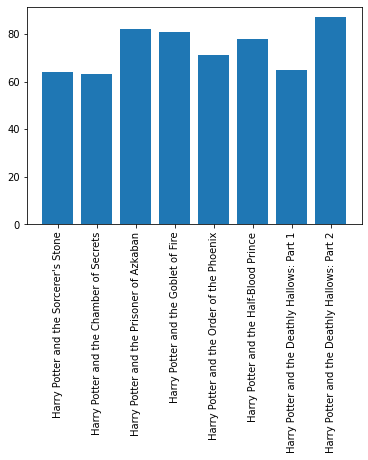

In [57]:
# query 
q_ = {'title' : {'$regex': 'Harry Potter'} }

# projection
p_ = {'_id':0,
      'title':1,
      'metacritic':1,
      'tomatoes.critic.rating':1,
      'imdb.rating':1,
     }

try:
    _ = db_mflix.movies.find(q_,p_)
#     for x in _:
#         pprint(x)
    df = pd.DataFrame(list(_))
except:
    print('Failed query')

plt.bar('title','metacritic',data=df)
plt.xticks(rotation=90)

#### 3 - Inspect the dataset to search for all mentions of movies that won one or more Oscar award (under the `text` subfield in `awards`), but are judged poorly by the viewers (Rotten Tomatoes viewer meter < 50). Select the five movies with the highest total number of awards won.

The proper regex expression is `[Ww]on [0-9]* [Oo]scars?`

This takes into account all following alternatives:
* won/Won
* oscar/Oscar/oscars/Oscars
* any number of Oscars (e.g. 1, 21, 19057...) 

In [58]:
# query 
q_ = {'awards.text' : {'$regex': '[Ww]on [0-9]* [Oo]scars?'}, 
      'tomatoes.viewer.meter' : {'$lt': 50} }

# projection
p_ = {'_id':0,
      'title':1,
      'awards':1,
      'tomatoes.viewer':1
     }

# sorting
s_ = [('awards.wins', -1)]

# limit
l_ = 5

try:
    _ = db_mflix.movies.find(q_, p_).sort(s_).limit(l_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'awards': {'nominations': 30,
            'text': 'Won 1 Oscar. Another 50 wins & 30 nominations.',
            'wins': 51},
 'title': 'Talk to Her',
 'tomatoes': {'viewer': {'meter': 35, 'numReviews': 1038, 'rating': 3.6}}}
{'awards': {'nominations': 10,
            'text': 'Won 1 Oscar. Another 9 wins & 10 nominations.',
            'wins': 10},
 'title': 'The Nutty Professor',
 'tomatoes': {'viewer': {'meter': 44, 'numReviews': 601579, 'rating': 2.9}}}
{'awards': {'nominations': 5,
            'text': 'Won 5 Oscars. Another 4 wins & 5 nominations.',
            'wins': 9},
 'title': 'Wilson',
 'tomatoes': {'viewer': {'meter': 49, 'numReviews': 342, 'rating': 3.4}}}
{'awards': {'nominations': 7,
            'text': 'Won 1 Oscar. Another 7 wins & 7 nominations.',
            'wins': 8},
 'title': 'California Suite',
 'tomatoes': {'viewer': {'meter': 46, 'numReviews': 2683, 'rating': 3.1}}}
{'awards': {'nominations': 17,
            'text': 'Won 1 Oscar. Another 6 wins & 17 nomination

The second method to perform a text search in MongoDB is via the full-text search functionality.
In newer versions of MongoDB this functionality is left for the fully-managed cloud database service offered by MongoDB (Atlas).

In this implementation, the full-text search is implemented using the Apache Lucene project, a Java library (with a Python wrapper) for text indexing and text search, also used in other NoSQL DBs such as Elasticsearch.

In standalone deployments of MongoDB, as the one we are working with, the full-text search functionality can be obtained with a "workaround":

1. Create an index of the field we want to search
2. Perform a query with the `$text` find operator

The `index` is an additional information we can assing to our Collection to ease MongoDB searches.
It can be though as the equivalent of the index of a book. We can use the index to quickly locate the pages where a given appears.
Similarly, in MongoDB we can create an index to quickly identify the documents containing analogous fields.


We first instruct MongoDB to create an index of type `text` associated to a given field:

```python
<DB OBJECT>.<COLLECTION NAME>.create_index([('THE FIELD', 'text')])
```

Then, we can perform a query based on full-text:

```python
<DB OBJECT>.<COLLECTION NAME>.find({ '$text' : {'$search' : "TEXT SEARCH" } })
```


To search for **exact** terms, **escape** the `"` symbols in the search, by using `\"`:

`"\"TEXT SEARCH\""`

To **exclude** terms from a search use the `-` symbols in front of the word to exclude, by using:

`"TEXT SEARCH -WORD"`

The text-search functionality will also provide a `score` for the text search, similarly to any search engine.
We can use this information to sort our text searches by the score. 

Test implementing a full-text search on the `title` field, and search for titles containing the text "Jurassic Park"

In [59]:
db_mflix.movies.create_index([('title', 'text')])

'title_text'

In [60]:
# query 
q_ = {'$text' : {'$search': 'Jurassic Park'},
}

# projection
p_ = {'_id':0,
      'title':1,
     }

try:
    _ = db_mflix.movies.find(q_, p_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'title': 'Jurassic World'}
{'title': 'Jurassic Park'}
{'title': 'Jurassic Park III'}
{'title': 'Jurassic Park III'}
{'title': 'The Lost World: Jurassic Park'}
{'title': 'Parked'}
{'title': 'Parking'}
{'title': 'Pervert Park'}
{'title': 'Blowfly Park'}
{'title': 'Mansfield Park'}
{'title': 'Paranoid Park'}
{'title': 'Wicker Park'}
{'title': 'Gosford Park'}
{'title': 'Ken Park'}
{'title': 'Mansfield Park'}
{'title': 'Dog Park'}
{'title': 'The Park Is Mine'}
{'title': 'Gorky Park'}
{'title': 'Barefoot in the Park'}
{'title': 'Broken Glass Park'}
{'title': 'The Central Park Five'}
{'title': 'Trailer Park Jesus'}
{'title': 'Hyde Park on Hudson'}
{'title': 'Trailer Park of Terror'}
{'title': 'The Delicate Art of Parking'}
{'title': 'The Rosa Parks Story'}
{'title': 'The Panic in Needle Park'}
{'title': "Trailer Park Boys: Don't Legalize It"}
{'title': 'Birders: The Central Park Effect'}
{'title': 'Guy and Madeline on a Park Bench'}
{'title': 'Trailer Park Boys: The Movie'}
{'title': 'Chestn

Explicitely require the entire phrase to be searched `"\"Jurassic Park\""`

In [61]:
# query 
q_ = {'$text' : {'$search': '\"Jurassic Park\"'},
}

# projection
p_ = {'_id':0,
      'title':1,
     }

try:
    _ = db_mflix.movies.find(q_, p_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'title': 'Jurassic Park'}
{'title': 'Jurassic Park III'}
{'title': 'Jurassic Park III'}
{'title': 'The Lost World: Jurassic Park'}


Search for all titles containing "Park" but exclude the word "Jurassic"

In [62]:
# query 
q_ = {'$text' : {'$search': 'Park -Jurassic'},
}

# projection
p_ = {'_id':0,
      'title':1,
     }

try:
    _ = db_mflix.movies.find(q_, p_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'title': 'Parked'}
{'title': 'Parking'}
{'title': 'Pervert Park'}
{'title': 'Blowfly Park'}
{'title': 'Mansfield Park'}
{'title': 'Paranoid Park'}
{'title': 'Wicker Park'}
{'title': 'Gosford Park'}
{'title': 'Ken Park'}
{'title': 'Mansfield Park'}
{'title': 'Dog Park'}
{'title': 'The Park Is Mine'}
{'title': 'Gorky Park'}
{'title': 'Barefoot in the Park'}
{'title': 'Broken Glass Park'}
{'title': 'The Central Park Five'}
{'title': 'Trailer Park Jesus'}
{'title': 'Hyde Park on Hudson'}
{'title': 'Trailer Park of Terror'}
{'title': 'The Delicate Art of Parking'}
{'title': 'The Rosa Parks Story'}
{'title': 'The Panic in Needle Park'}
{'title': "Trailer Park Boys: Don't Legalize It"}
{'title': 'Birders: The Central Park Effect'}
{'title': 'Guy and Madeline on a Park Bench'}
{'title': 'Trailer Park Boys: The Movie'}
{'title': 'Chestnut: Hero of Central Park'}
{'title': 'South Park: Bigger Longer & Uncut'}
{'title': 'Trailer Park Boys: Countdown to Liquor Day'}


Including the score in the sorting of the results is a bit more complex, as it requires adding an additional `score` field defined as a `$meta` variable...

```python
[('score', { "$meta":"textScore" })]
```

It goes definitely beyond the scope of this exercise to unpack and undestand all that... The MongoDB documentation does an excellet work in describing the details for those interested:
https://docs.mongodb.com/manual/core/link-text-indexes/

However, it is interesting to see how we can perfor a Google-like search on arbitrarily complex documents with MongoDB.

In [63]:
# query 
q_ = {'$text' : {'$search': 'Jurassic Park'} }

# projection
p_ = {'_id':0,
      'title':1,
     }

# sorting
s_ = [('score', { "$meta":"textScore" })]

try:
    _ = db_mflix.movies.find(q_,p_).sort(s_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'title': 'Jurassic Park'}
{'title': 'Jurassic Park III'}
{'title': 'Jurassic Park III'}
{'title': 'The Lost World: Jurassic Park'}
{'title': 'Parked'}
{'title': 'Parking'}
{'title': 'Gorky Park'}
{'title': 'Gosford Park'}
{'title': 'Paranoid Park'}
{'title': 'Pervert Park'}
{'title': 'Mansfield Park'}
{'title': 'Wicker Park'}
{'title': 'Barefoot in the Park'}
{'title': 'The Park Is Mine'}
{'title': 'Blowfly Park'}
{'title': 'Mansfield Park'}
{'title': 'Dog Park'}
{'title': 'Ken Park'}
{'title': 'Jurassic World'}
{'title': 'Trailer Park Jesus'}
{'title': 'The Panic in Needle Park'}
{'title': 'Broken Glass Park'}
{'title': 'Hyde Park on Hudson'}
{'title': 'The Rosa Parks Story'}
{'title': 'Trailer Park of Terror'}
{'title': 'The Central Park Five'}
{'title': 'The Delicate Art of Parking'}
{'title': 'Trailer Park Boys: The Movie'}
{'title': 'Guy and Madeline on a Park Bench'}
{'title': 'Birders: The Central Park Effect'}
{'title': "Trailer Park Boys: Don't Legalize It"}
{'title': 'Chestn

## 08 - Aggregation Queries

More complex and articulated queries can be performed via the `$expr` aggregator expression and the Aggregation Pipeline.

The aggregator expression queries, or `$expr`-based, are queries where the conditions are set on the **content** of the fields themselves.

For instance, we can ask to retrieve all documents where the IMDb Rating is higher than the Rotten Tomatoes Critics Rating (e.g. "IMDb Rating > Rotten Tomatoes Critics Rating").

This implies accessing and comparing the values of both fields to perform the query, instead of comparing the value of one field with a "static" and external value (e.g. "IMDb Rating > 8.5")

To perform a query based on the `$expr` condition, we use the syntax:

```python
<DB_OBJECT>.<COLLECTION_NAME>.find( '$expr' : { '<COMPARISON OPERATOR>': [ '$FIELD_1', 
                                                                           '$FIELD_2']}
                                  )
```

* Find 5 movies where the IMDB Rating is higher than the Rotten Tomatoes Critics Rating
    * Make sure the two fields exist in the document (check the `$exists` operator)

In [64]:
# query 
q_ = {'imdb.rating' : {'$exists': True},
      'tomatoes.critic.rating' : {'$exists': True},
      '$expr' : {'$gt': ['$imdb.rating', '$tomatoes.critic.rating']} }

# projection
p_ = {'_id':0,
      'title':1,
      'imdb':1,
      'tomatoes':1,
     }

# limit
l_ = 5

try:
    _ = db_mflix.movies.find(q_,p_).limit(l_)
    for x in _:
        pprint(x)
except:
    print('Failed query')

{'imdb': {'id': 13571, 'rating': 6.6, 'votes': 466},
 'title': 'Salomè',
 'tomatoes': {'critic': {'meter': 60, 'numReviews': 5, 'rating': 6.5},
              'fresh': 3,
              'lastUpdated': datetime.datetime(2015, 6, 13, 19, 0, 41),
              'rotten': 2,
              'viewer': {'meter': 70, 'numReviews': 310, 'rating': 3.9}}}
{'imdb': {'id': 15016, 'rating': 7.3, 'votes': 1276},
 'title': 'The Iron Horse',
 'tomatoes': {'critic': {'meter': 75, 'numReviews': 8, 'rating': 7.2},
              'dvd': datetime.datetime(2006, 2, 14, 0, 0),
              'fresh': 6,
              'lastUpdated': datetime.datetime(2015, 7, 23, 18, 58, 55),
              'rotten': 2,
              'viewer': {'meter': 83, 'numReviews': 521, 'rating': 3.7}}}
{'imdb': {'id': 15873, 'rating': 7.9, 'votes': 677},
 'title': "Grass: A Nation's Battle for Life",
 'tomatoes': {'critic': {'meter': 100, 'numReviews': 5, 'rating': 7.6},
              'dvd': datetime.datetime(2000, 3, 28, 0, 0),
              

To proceed towards further aggregations based on the very powerful and expressive Aggregation Pipeline it is required to dig deeper into the documentation to explore the vast number of aggregator operators: https://docs.mongodb.com/manual/reference/operator/aggregation-pipeline/

We will limit to 2 here:
1. match
2. group

`$match` provides a way to filter the data as in a "standard" `find` query operation.

`$group` will perform similar aggregation to the SQL equivalent `GROUP BY`, by combining all records based on the value of a specific field, and evaluating cumulative information (such as sum, count, max, ...)

To work with aggregations in pymongo, we use `aggregate` instead of `find`:

```python
<DB_OBJECT>.<COLLECTION_NAME>.aggregate( [...] )
```

And we pass to the `aggregate` method the list of operations we want to affect our documents.
*The ordering of the aggregations is extremely important*. All aggregation operations will be performed in series, each one acting on the output of the previous.

```python
[{<AGGREGATION OPERATION 1>},
 {<AGGREGATION OPERATION 2>}]
```

The `$match` aggregation operator acts almost identically to a normal `find` query:

```python
{'$match' : {<FIELD 1> : <CONDITION 1>,
             <FIELD 2> : <CONDITION 2>} }
```

To express a groupby in pymongo, we first express the new `"_id"`, the unique field on which to perform the aggregation.
Then, we declare other fields and we match them to the result of aggregation functions such as `$sum` or `$max`.

```python
{'$group' : {'_id' : <$VALUE OF THE FIELD TO GROUP BY>,
             '<NEW AGGREGATE FIELD>' : { $<AGGREGATION OPERATOR> : $<VALUE OF THE FIELD TO AGGREGATE> } 
             } }
```

Let's try to implement a simple query with the MongoDB Aggregation Pipeline.

Let's evaluate:

* the distribution of the number of movies versus the Rating set by Rotten Tomatoes Viewers
    * and the average number of Rotten Tomatoes Viewers Reviews versus their Rating
        * filtering only those movies produced after year 2000
        
To work this query out, proceed by performing the following steps:

1. Define the `$match` operator, acting on the `year` feature
2. Define the `$group` operator, with the unique identifier being the *value* (`$`) of `tomatoes.viewer.rating`
3. Include the two aggregations:
    - A `count`  field using the `$sum` operator
    - A `avgRev` field using the `$avg` operator on the *value* (`$`) of `tomatoes.viewer.numReviews`
4. Return the result of the aggregation in a `pandas` DataFrame and plot both distributions as scatter plots

In [65]:
_ = db_mflix.movies.aggregate([ 
                              # select all movies after 2000
                              {'$match'  : {
                                      'year' : {'$gt' : 2000}
                                  } 
                              },
                              # group by the value of tomatoes.viewer.rating
                              {'$group': {
                                      '_id' : '$tomatoes.viewer.rating',
                                      # count all documents
                                      'count' : { '$sum' : 1 },
                                      # get the average number of reviews per movie
                                      'avgRev': { '$avg' : '$tomatoes.viewer.numReviews'},
                                  } 
                              }
                              ])

In [66]:
df = pd.DataFrame(list(_))

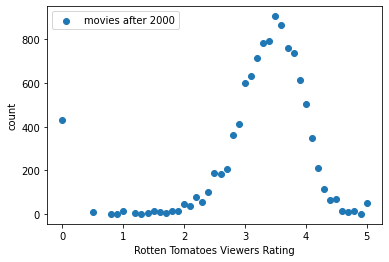

In [67]:
plt.scatter(x='_id',
            y='count',
            data=df, 
            label='movies after 2000')
plt.xlabel("Rotten Tomatoes Viewers Rating")
plt.ylabel("count")
plt.legend(loc='best')

Text(0, 0.5, 'Average number of reviews')

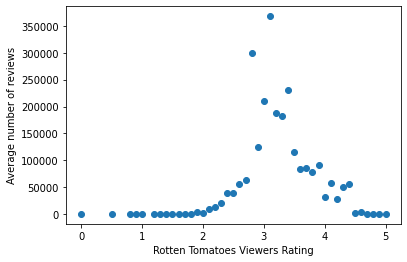

In [68]:
plt.scatter(x='_id',
            y='avgRev',
            data=df, 
            label='movies after 2000')
plt.xlabel("Rotten Tomatoes Viewers Rating")
plt.ylabel("Average number of reviews")

1. Plot the average, min and max movie runtime by year. Avoid including documents with type `series`.


2. Find the best rating Metacritic assigned each year, starting from 1995 onwards. Limit the result to only those movies with at least 1 award nomination and more than 1000 IMDb votes.


3. Group movies by directors (use the full list to select also "join ventures" of multiple directors), and draw a scatter plot of the number of their movies vs their average IMDB rating, limiting to directors with more than 10 and less than 50 movies.


4. Select movies that won at least 1 Golden Globe award starting from 1980 (try using `regex`). Group them by the country and plot the number of Golden Globes won per each country.
   * The `countries` field is a list... to properly count all times each country enters in the list we need to use the `$unwind` operator. Check it out on the documentation [here](https://docs.mongodb.com/manual/reference/operator/aggregation/unwind/)

#### 1 - Plot the average, min and max movie runtime by year. Avoid including documents with type `series`.

Text(0, 0.5, 'runtime (min)')

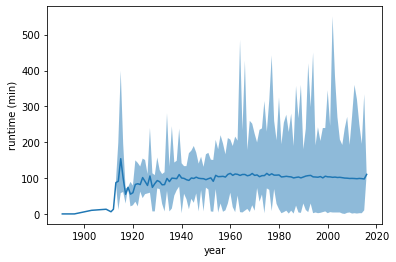

In [69]:
_ = db_mflix.movies.aggregate([ 
                              # exclude series from the selection
                              {'$match'  : {
                                      'type' : {'$ne' : 'series'},
                                  } 
                              },
                              # group by year
                              {'$group': {
                                      '_id' : '$year',
                                      # get the average runtime
                                      'avgRT': { '$avg' : '$runtime'},
                                      # get the min runtime
                                      'minRT': { '$min' : '$runtime'},
                                      # get the max runtime
                                      'maxRT': { '$max' : '$runtime'},
                                  } 
                              },
                              ])
df = pd.DataFrame(list(_)).sort_values(by='_id')
plt.plot('_id','avgRT',data=df)
plt.fill_between('_id','minRT','maxRT',data=df, alpha=0.5)
plt.xlabel('year')
plt.ylabel('runtime (min)')

#### 2 - Find the best rating Metacritic assigned each year, starting from 1995 onwards. Limit the result to only those movies with at least 1 award nomination and more than 1000 IMDb votes.

Text(0, 0.5, 'Average IMDb rating')

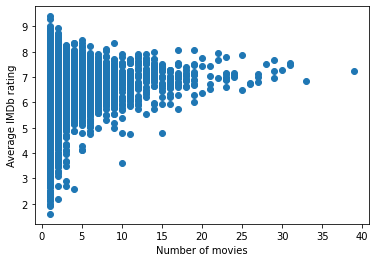

In [70]:
_ = db_mflix.movies.aggregate([ 
                              # group by the main director
                              {'$group': {
                                      '_id' : '$directors',
                                      # count all documents
                                      'count' : { '$sum' : 1 },
                                      # get the average number of reviews per movie
                                      'avgRev': { '$avg' : '$imdb.rating'},
                                  } 
                              },
                              # select only those where count > 10
                              {'$match'  : {
                                      'count' : {'$gt' : 10},
                                      'count' : {'$lt' : 50}
                                  } 
                              },
                              ])
df = pd.DataFrame(list(_))
plt.scatter('count','avgRev',data=df)
plt.xlabel('Number of movies')
plt.ylabel('Average IMDb rating')

#### 3 - Group movies by directors (use the full list to select also "join ventures" of multiple directors), and draw a scatter plot of the number of their movies vs their average IMDB rating, limiting to directors with more than 10 and less than 50 movies.

Text(0, 0.5, 'Max metacritic score')

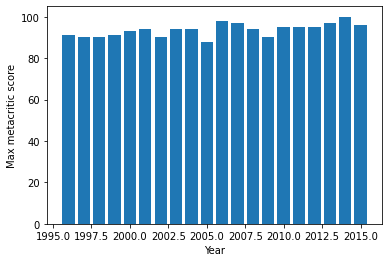

In [71]:
_ = db_mflix.movies.aggregate([ 
                              # select movies 
                              {'$match'  : {
                                      # from 1995 onward
                                      'year' : {'$gt' : 1995},
                                      # AND at least 1000 IMDb votes
                                      'imdb.votes' : {'$gt' : 1000},
                                      # AND at least 1 award nomination
                                      'awards.nominations' : {'$gt' : 1}
                                  } 
                              },
                              # group by year
                              {'$group': {
                                      '_id' : '$year',
                                      # get max Metacritic score
                                      'maxMeta': { '$max' : '$metacritic'},
                                  } 
                              },
                              ])
df = pd.DataFrame(list(_))
plt.bar('_id','maxMeta',data=df)
plt.xlabel('Year')
plt.ylabel('Max metacritic score')

#### 4 - Select movies that won at least 1 Golden Globe award starting from 1980 (try using `regex`). Group them by the country and plot the number of Golden Globes won per each country.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

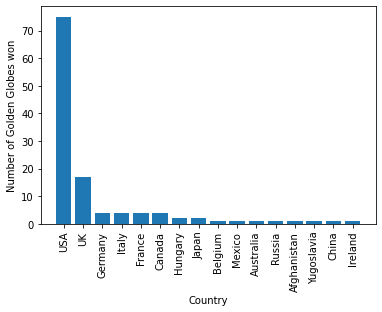

In [72]:
_ = db_mflix.movies.aggregate([ 
                              # select movies 
                              {'$match'  : {
                                      # from 1980 onward
                                      'year' : {'$gt' : 1980},
                                      # AND won at least 1 Golden Globe
                                      'awards.text' : {'$regex' : "[wW]on [0-9]* [gG]olden [gG]lobes?"}
                                  } 
                              },
                              # unwind the country list to return 1 document
                              # per each country in the original document 
                              {'$unwind': '$countries'},
                              # group by country
                              {'$group': {
                                      '_id' : '$countries',
                                      # count the occurrencies
                                      'count' : { '$sum' : 1 },
                                  } 
                              },
                              # sort descending by count
                              {'$sort': {
                                      'count' : -1,
                                  } 
                              },
                              ])
df = pd.DataFrame(list(_))
plt.bar('_id','count',data=df)
plt.xlabel('Country')
plt.ylabel('Number of Golden Globes won')
plt.xticks(rotation=90)